In [1]:
# STEP 1: Imports
import pandas as pd
import numpy as np
import glob
import re
import random
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nabee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# STEP 2: Load dataset
path = "archive/"  # change if your folder name differs
files = glob.glob(path + "*.csv")

df_list = []
for file in files:
    temp = pd.read_csv(file)
    temp.columns = [c.lower().strip() for c in temp.columns]  # normalize column names
    temp = temp.rename(columns={'text': 'clause_text'})  # fix inconsistent names
    temp['category'] = file.split('/')[-1].replace('.csv', '').replace('.CSV', '')
    df_list.append(temp)

df = pd.concat(df_list, ignore_index=True)
print("Total clauses:", len(df))
df.head()


Total clauses: 150881


,clause_text,clause_type,category
0,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events,archive\absence-of-certain-changes-or-events
1,Absence of Certain Changes or Events. Since Ma...,absence-of-certain-changes-or-events,archive\absence-of-certain-changes-or-events
2,Absence of Certain Changes or Events. (a) Sinc...,absence-of-certain-changes-or-events,archive\absence-of-certain-changes-or-events
3,Absence of Certain Changes or Events. Since th...,absence-of-certain-changes-or-events,archive\absence-of-certain-changes-or-events
4,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events,archive\absence-of-certain-changes-or-events


In [3]:
# STEP 3: Deep preprocessing

stop_words = set(stopwords.words('english'))

def deep_clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\n', ' ', text)                 # remove line breaks
    text = re.sub(r'\s+', ' ', text)                # remove extra spaces
    text = re.sub(r'\d+', '', text)                 # remove numbers
    text = re.sub(r'[^a-z\s]', '', text)            # remove punctuation
    text = re.sub(r'\bsection\b|\bclause\b', '', text)  # remove generic legal terms
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

df['clean_clause'] = df['clause_text'].astype(str).apply(deep_clean_text)
df.dropna(subset=['clean_clause'], inplace=True)
df.drop_duplicates(subset=['clean_clause'], inplace=True)

print("Unique clauses after cleaning:", len(df))
df.head()


Unique clauses after cleaning: 148195


,clause_text,clause_type,category,clean_clause
0,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events,archive\absence-of-certain-changes-or-events,absence certain changes events except set fort...
1,Absence of Certain Changes or Events. Since Ma...,absence-of-certain-changes-or-events,archive\absence-of-certain-changes-or-events,absence certain changes events since march exc...
2,Absence of Certain Changes or Events. (a) Sinc...,absence-of-certain-changes-or-events,archive\absence-of-certain-changes-or-events,absence certain changes events since december ...
3,Absence of Certain Changes or Events. Since th...,absence-of-certain-changes-or-events,archive\absence-of-certain-changes-or-events,absence certain changes events since date comp...
4,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events,archive\absence-of-certain-changes-or-events,absence certain changes events except set fort...


In [4]:
# STEP 4: Split data by category
train_parts, test_parts = [], []

for cat in df['category'].unique():
    cat_df = df[df['category'] == cat]
    if len(cat_df) < 3:  # skip extremely small categories
        continue
    tr, ts = train_test_split(cat_df, test_size=0.2, random_state=42)
    train_parts.append(tr)
    test_parts.append(ts)

train_df = pd.concat(train_parts)
test_df = pd.concat(test_parts)

print(f"Training clauses: {len(train_df)} | Testing clauses: {len(test_df)}")


Training clauses: 118451 | Testing clauses: 29744


In [5]:
# STEP 5: Create balanced clause pairs
def create_balanced_pairs(df, n_per_cat=200):
    pairs = []
    cats = df['category'].unique()
    for cat in cats:
        same = df[df['category'] == cat]['clean_clause'].values
        diff = df[df['category'] != cat]['clean_clause'].values

        if len(same) < 2:
            continue

        # Positive pairs
        for _ in range(n_per_cat // 2):
            a, b = np.random.choice(same, 2, replace=False)
            pairs.append((a, b, 1))

        # Negative pairs
        for _ in range(n_per_cat // 2):
            a = np.random.choice(same)
            b = np.random.choice(diff)
            pairs.append((a, b, 0))
    
    random.shuffle(pairs)
    return pd.DataFrame(pairs, columns=['clause1', 'clause2', 'label'])

pairs_train = create_balanced_pairs(train_df)
pairs_test = create_balanced_pairs(test_df)

print("Training pairs:", len(pairs_train))
print("Testing pairs:", len(pairs_test))
pairs_train.head()


Training pairs: 78800
Testing pairs: 78800


,clause1,clause2,label
0,indemnification contribution indemnification c...,indemnification contribution chevron agrees in...,1
1,assignability employee may assign agreement th...,investment company act lender represents warra...,0
2,additional agreements order expand flowerss ex...,additional agreements company shall use commer...,1
3,guaranty guarantor irrevocably absolutely unco...,general goods shall procured accordance provis...,0
4,applicable law extent preempted laws united st...,applicable law agreement shall construed gover...,1


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 120

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(pd.concat([pairs_train['clause1'], pairs_train['clause2']]))

def prepare_sequences(pairs, tokenizer, max_len=MAX_LEN):
    X1 = tokenizer.texts_to_sequences(pairs['clause1'])
    X2 = tokenizer.texts_to_sequences(pairs['clause2'])
    X1 = pad_sequences(X1, maxlen=max_len, padding='post', truncating='post')
    X2 = pad_sequences(X2, maxlen=max_len, padding='post', truncating='post')
    y = pairs['label'].values
    return X1, X2, y

X1_train, X2_train, y_train = prepare_sequences(pairs_train, tokenizer)
X1_test, X2_test, y_test = prepare_sequences(pairs_test, tokenizer)

print("Train shapes:", X1_train.shape, X2_train.shape, y_train.shape)
print("Test shapes:", X1_test.shape, X2_test.shape, y_test.shape)


Train shapes: (78800, 120) (78800, 120) (78800,)
Test shapes: (78800, 120) (78800, 120) (78800,)


In [7]:
for i in range(5):
    print(f"\nLabel: {pairs_train.loc[i, 'label']}")
    print("Clause 1:", pairs_train.loc[i, 'clause1'][:200])
    print("Clause 2:", pairs_train.loc[i, 'clause2'][:200])



Label: 1
Clause 1: indemnification contribution indemnification contribution provisions set forth hereof contravene chilean law public policy
Clause 2: indemnification contribution chevron agrees indemnify hold harmless underwriter person controls underwriter within meaning either act exchange act losses claims damages liabilities joint several may b

Label: 0
Clause 1: assignability employee may assign agreement third party whatever purpose without express written consent company company may assign agreement third party without express written consent employee excep
Clause 2: investment company act lender represents warrants qualified purchaser within meaning investment company act amended

Label: 1
Clause 1: additional agreements order expand flowerss exposure aol service beyond aolcontrolled areas aol shall use commercially reasonable efforts assist flowers establishing promotional marketing advertising 
Clause 2: additional agreements company shall use commercially reasonable effo

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBED_DIM = 128
LSTM_UNITS = 64

# Define shared embedding + encoder
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN)

input_1 = Input(shape=(MAX_LEN,))
input_2 = Input(shape=(MAX_LEN,))

encoded_1 = Bidirectional(LSTM(LSTM_UNITS, return_sequences=False))(embedding(input_1))
encoded_2 = Bidirectional(LSTM(LSTM_UNITS, return_sequences=False))(embedding(input_2))

merged = concatenate([encoded_1, encoded_2])
dense = Dense(128, activation='relu')(merged)
drop = Dropout(0.4)(dense)
output = Dense(1, activation='sigmoid')(drop)

model_bilstm = Model(inputs=[input_1, input_2], outputs=output)
model_bilstm.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

model_bilstm.summary()


C:\Users\nabee\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 120)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 120)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 120, 128)          │       4,349,952 │ input_layer[0][0],         │
│                               │                           │                 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 128)               │          98,816 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_1               │ (None, 128)               │          98,816 │ embedding[1][0]            │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 256)               │               0 │ bidirectional[0][0],       │
│                               │                           │                 │ bidirectional_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │          32,896 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │             129 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,580,609 (17.47 MB)

 Trainable params: 4,580,609 (17.47 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history_bilstm = model_bilstm.fit(
    [X1_train, X2_train], y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)


Epoch 1/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 383s 336ms/step - accuracy: 0.8591 - loss: 0.2893 - val_accuracy: 0.9594 - val_loss: 0.1502
Epoch 2/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 370s 334ms/step - accuracy: 0.9618 - loss: 0.1319 - val_accuracy: 0.9650 - val_loss: 0.1251
Epoch 3/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 367s 331ms/step - accuracy: 0.9674 - loss: 0.1120 - val_accuracy: 0.9689 - val_loss: 0.1158
Epoch 4/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 363s 327ms/step - accuracy: 0.9702 - loss: 0.1030 - val_accuracy: 0.9728 - val_loss: 0.1061
Epoch 5/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 402s 345ms/step - accuracy: 0.9763 - loss: 0.0811 - val_accuracy: 0.9725 - val_loss: 0.1087
Epoch 6/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 384s 346ms/step - accuracy: 0.9815 - loss: 0.0659 - val_accuracy: 0.9789 - val_loss: 0.0997
Epoch 7/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 384s 347ms/step - accuracy: 0.9866 - loss: 0.0489 - val_accuracy: 0.9846 - val_loss: 0.0775
Epoch 8/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 396s 357ms/step - ac

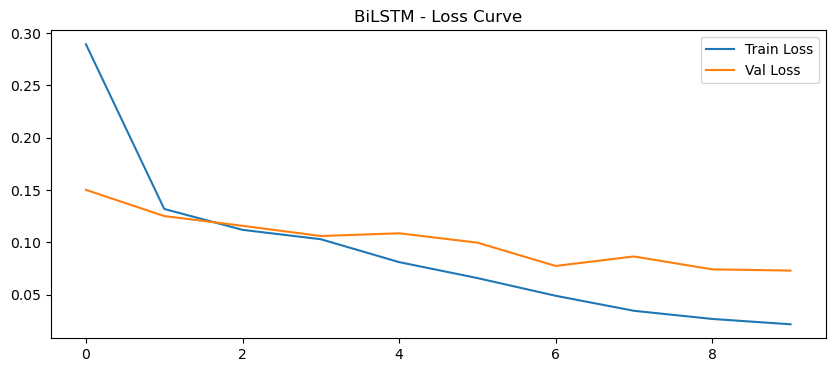

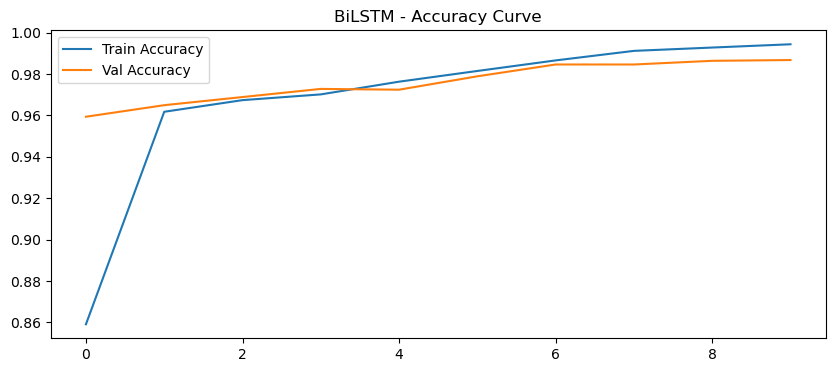

In [10]:
plt.figure(figsize=(10,4))
plt.plot(history_bilstm.history['loss'], label='Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("BiLSTM - Loss Curve")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history_bilstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("BiLSTM - Accuracy Curve")
plt.show()


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred_prob = model_bilstm.predict([X1_test, X2_test])
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_prob)

print("=== BiLSTM Performance ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")


2463/2463 ━━━━━━━━━━━━━━━━━━━━ 121s 49ms/step
=== BiLSTM Performance ===
Accuracy: 0.9876
Precision: 0.9800
Recall: 0.9956
F1-Score: 0.9877
ROC-AUC: 0.9963


In [12]:
for i in range(5):
    print(f"\nTrue Label: {y_test[i]}, Predicted: {int(y_pred[i])}, Score: {float(y_pred_prob[i])}")
    print("Clause 1:", pairs_test.loc[i, 'clause1'][:200])
    print("Clause 2:", pairs_test.loc[i, 'clause2'][:200])



True Label: 0, Predicted: 0, Score: 0.0
Clause 1: effect headings headings herein convenience shall affect construction thereof doc usv
Clause 2: exclusivity indemnification provided shall deemed exclusive rights indemnified person may entitled agreement matter law otherwise action indemnified persons official capacity action another capacity s

True Label: 1, Predicted: 1, Score: 0.9927605390548706
Clause 1: noncompetition executive agrees company following provisions executive acknowledges agrees necessary protect companys legitimate business interests executive covenants agrees company
Clause 2: noncompetition subject article employee employees period employment aramark period two years following voluntary involuntary termination employment shall without aramarks written permission shall gran

True Label: 0, Predicted: 0, Score: 1.3613610566896725e-19
Clause 1: reinstatement reinstatement used selection shall made reinstating former employee
Clause 2: subordination companys payment

C:\Users\nabee\AppData\Local\Temp\ipykernel_10744\1902416420.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"\nTrue Label: {y_test[i]}, Predicted: {int(y_pred[i])}, Score: {float(y_pred_prob[i])}")


In [13]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate, Layer
import tensorflow as tf
from tensorflow.keras.models import Model

# --- Custom Attention Layer ---
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super().build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# --- Define the model ---
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBED_DIM = 128
LSTM_UNITS = 64

input_1 = Input(shape=(MAX_LEN,))
input_2 = Input(shape=(MAX_LEN,))

embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN)

lstm_1 = LSTM(LSTM_UNITS, return_sequences=True)(embedding(input_1))
lstm_2 = LSTM(LSTM_UNITS, return_sequences=True)(embedding(input_2))

att_1 = AttentionLayer()(lstm_1)
att_2 = AttentionLayer()(lstm_2)

merged = concatenate([att_1, att_2])
dense = Dense(128, activation='relu')(merged)
drop = Dropout(0.3)(dense)
output = Dense(1, activation='sigmoid')(drop)

model_attention = Model(inputs=[input_1, input_2], outputs=output)
model_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_attention.summary()


C:\Users\nabee\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 120)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 120)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 120, 128)          │       4,349,952 │ input_layer_2[0][0],       │
│                               │                           │                 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 120, 64)           │          49,408 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ (None, 120, 64)           │          49,408 │ embedding_1[1][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_layer               │ (None, 64)                │             184 │ lstm_2[0][0]               │
│ (AttentionLayer)              │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_layer_1             │ (None, 64)                │             184 │ lstm_3[0][0]               │
│ (AttentionLayer)              │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 128)               │               0 │ attention_layer[0][0],     │
│                               │                           │                 │ attention_layer_1[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │          16,512 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │             129 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,465,777 (17.04 MB)

 Trainable params: 4,465,777 (17.04 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history_att = model_attention.fit(
    [X1_train, X2_train], y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1
)


Epoch 1/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 266s 231ms/step - accuracy: 0.6583 - loss: 0.5934 - val_accuracy: 0.7075 - val_loss: 0.4992
Epoch 2/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 250s 225ms/step - accuracy: 0.8593 - loss: 0.3381 - val_accuracy: 0.9228 - val_loss: 0.2262
Epoch 3/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 248s 223ms/step - accuracy: 0.9349 - loss: 0.1993 - val_accuracy: 0.9365 - val_loss: 0.1865
Epoch 4/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 249s 225ms/step - accuracy: 0.9517 - loss: 0.1583 - val_accuracy: 0.9536 - val_loss: 0.1545
Epoch 5/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 251s 226ms/step - accuracy: 0.9109 - loss: 0.3087 - val_accuracy: 0.9353 - val_loss: 0.2014
Epoch 6/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 250s 226ms/step - accuracy: 0.9478 - loss: 0.1698 - val_accuracy: 0.9406 - val_loss: 0.2024
Epoch 7/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 249s 225ms/step - accuracy: 0.9607 - loss: 0.1347 - val_accuracy: 0.9546 - val_loss: 0.1672
Epoch 8/10
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 244s 220ms/step - ac

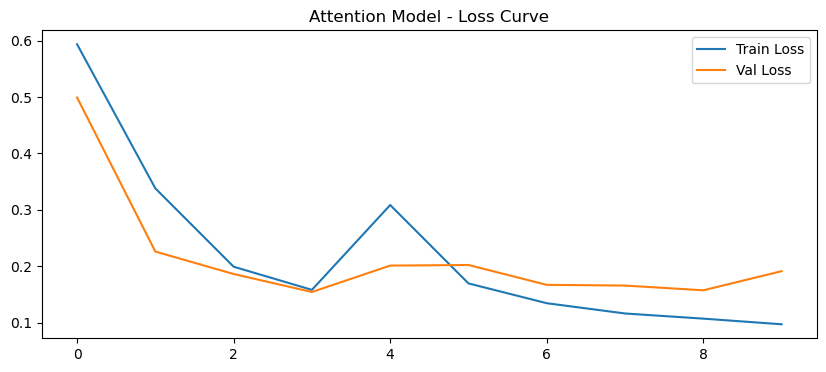

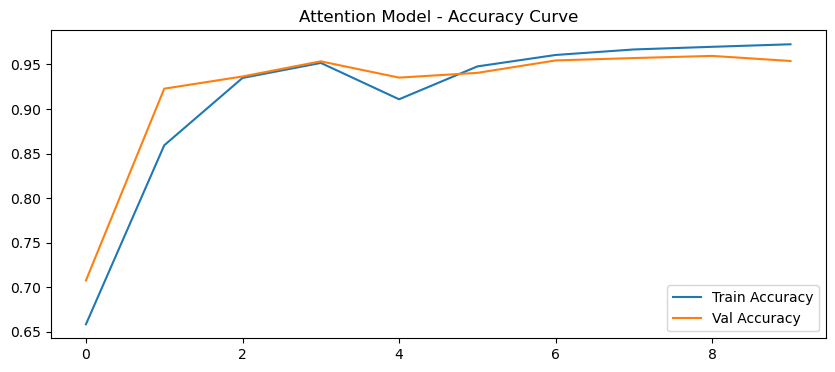

In [15]:
plt.figure(figsize=(10,4))
plt.plot(history_att.history['loss'], label='Train Loss')
plt.plot(history_att.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Attention Model - Loss Curve")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history_att.history['accuracy'], label='Train Accuracy')
plt.plot(history_att.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Attention Model - Accuracy Curve")
plt.show()


In [16]:
y_pred_prob2 = model_attention.predict([X1_test, X2_test])
y_pred2 = (y_pred_prob2 > 0.5).astype(int)

acc2 = accuracy_score(y_test, y_pred2)
prec2 = precision_score(y_test, y_pred2)
rec2 = recall_score(y_test, y_pred2)
f12 = f1_score(y_test, y_pred2)
roc2 = roc_auc_score(y_test, y_pred_prob2)

print("=== Attention Model Performance ===")
print(f"Accuracy: {acc2:.4f}")
print(f"Precision: {prec2:.4f}")
print(f"Recall: {rec2:.4f}")
print(f"F1-Score: {f12:.4f}")
print(f"ROC-AUC: {roc2:.4f}")


2463/2463 ━━━━━━━━━━━━━━━━━━━━ 85s 34ms/step 
=== Attention Model Performance ===
Accuracy: 0.9513
Precision: 0.9189
Recall: 0.9899
F1-Score: 0.9531
ROC-AUC: 0.9688


In [17]:
results = pd.DataFrame({
    'Model': ['BiLSTM', 'Attention Encoder'],
    'Accuracy': [acc, acc2],
    'Precision': [prec, prec2],
    'Recall': [rec, rec2],
    'F1-Score': [f1, f12],
    'ROC-AUC': [roc, roc2]
})
print(results)


               Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0             BiLSTM  0.987627   0.980012  0.995558  0.987724  0.996334
1  Attention Encoder  0.951282   0.918907  0.989924  0.953094  0.968811


In [18]:
for i in range(5):
    print(f"\nTrue Label: {y_test[i]}, Predicted: {int(y_pred2[i])}, Score: {float(y_pred_prob2[i])}")
    print("Clause 1:", pairs_test.loc[i, 'clause1'][:200])
    print("Clause 2:", pairs_test.loc[i, 'clause2'][:200])



True Label: 0, Predicted: 0, Score: 1.3623203946566665e-37
Clause 1: effect headings headings herein convenience shall affect construction thereof doc usv
Clause 2: exclusivity indemnification provided shall deemed exclusive rights indemnified person may entitled agreement matter law otherwise action indemnified persons official capacity action another capacity s

True Label: 1, Predicted: 1, Score: 0.9827264547348022
Clause 1: noncompetition executive agrees company following provisions executive acknowledges agrees necessary protect companys legitimate business interests executive covenants agrees company
Clause 2: noncompetition subject article employee employees period employment aramark period two years following voluntary involuntary termination employment shall without aramarks written permission shall gran

True Label: 0, Predicted: 0, Score: 1.0250116844190416e-07
Clause 1: reinstatement reinstatement used selection shall made reinstating former employee
Clause 2: subordinati

C:\Users\nabee\AppData\Local\Temp\ipykernel_10744\903785199.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"\nTrue Label: {y_test[i]}, Predicted: {int(y_pred2[i])}, Score: {float(y_pred_prob2[i])}")
